In [26]:

using JSON
using Glob
using Dates
using Plots
using ProgressMeter
using DataFrames
using CSV


include("../src/modelHDSparse.jl")
include("../src/encoding.jl")
include("../src/coarseEncoding.jl")


encodeDataset2SparseMat (generic function with 1 method)

## Generate Test Data

In [5]:

struct Data2D
    
    x::Float64
    y::Float64
    
end

dist2D(pt1::Data2D, pt2::Data2D) = (pt1.x-pt2.x)^2 + (pt1.y-pt2.y)^2


nData = 500000
data = [Data2D(0., 0.)]
while length(data) < nData
    x, y = 2*rand()-1, 2*rand()-1
    if x^2 + y^2 < 1.
        push!(data, Data2D(x, y))
    end
end


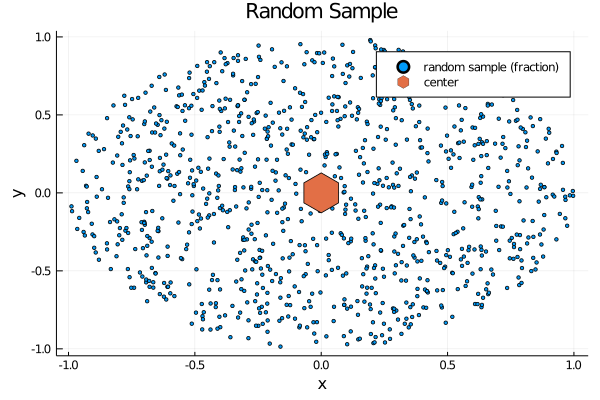

In [6]:

scatter(map(d -> d.x, data[1:1000]),
        map(d -> d.y, data[1:1000]),
        label="random sample (fraction)", marker=(:circle,2,1.))

scatter!([data[1].x], [data[1].y],
         label="center", marker=(:hexagon, 20, 1.), 
         xlabel = "x", ylabel="y", title="Random Sample")


### Specify Coarse Encoding

In [9]:

dimensions = [:x, :y]
nLattices = 1


maximas = Dict(:x => maximum(map(d -> d.x, data)),
               :y => maximum(map(d -> d.y, data)))

minimas = Dict(:x => minimum(map(d -> d.x, data)),
               :y => minimum(map(d -> d.y, data)))

resolution = Dict(:x => 0.3,
                  :y => 0.3)


@time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
@time lattice = generateLattice(coarseEncoder);


  0.050974 seconds (50.35 k allocations: 2.405 MiB)
  0.627505 seconds (496.16 k allocations: 24.749 MiB, 6.47% gc time)


### Encode Data

In [24]:

dicData = map(d -> Dict(:x => d.x, :y => d.y), data)[1]
@time hdvec = encodeData2SparseVec(dicData, coarseEncoder, lattice)


  0.062228 seconds (101.30 k allocations: 5.104 MiB)


100-element SparseVector{Int64,Int64} with 1 stored entry:
  [36 ]  =  1

In [27]:

dicsData = map(d -> Dict(:x => d.x, :y => d.y), data)
@time sparseHDM = encodeDataset2SparseMat(dicsData, coarseEncoder, lattice)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03m


  4.323283 seconds (12.74 M allocations: 407.109 MiB, 11.63% gc time)


500000×100 SparseMatrixCSC{Int64,Int64} with 500000 stored entries:
  [153   , 11]  =  1
  [262   , 11]  =  1
  [302   , 11]  =  1
  [364   , 11]  =  1
  [418   , 11]  =  1
  [766   , 11]  =  1
  [1216  , 11]  =  1
  [1279  , 11]  =  1
  [1816  , 11]  =  1
  [2565  , 11]  =  1
  [2615  , 11]  =  1
  [2760  , 11]  =  1
  ⋮
  [496845, 70]  =  1
  [496924, 70]  =  1
  [497203, 70]  =  1
  [497294, 70]  =  1
  [497766, 70]  =  1
  [497933, 70]  =  1
  [497956, 70]  =  1
  [498501, 70]  =  1
  [498994, 70]  =  1
  [499275, 70]  =  1
  [499482, 70]  =  1
  [499641, 70]  =  1
  [499863, 70]  =  1

### Compare Searches && Sizes

#### Sizes

In [28]:
println("size of HD data: ", Base.summarysize(sparseHDM))
println("size of 2D data: ", Base.summarysize(data))

size of HD data: 8000968
size of 2D data: 8000040


#### HD Search

In [29]:
hdvec = sparseHDM[1,:]
# time to compute distances
@time [sparseHDM * hdvec for i=1:100];
# time to filter
@time [(res = sparseHDM * hdvec;
        filter(idval -> idval[2] > 2.,  collect(zip(res.nzind, res.nzval)))) for i=1:100];

  1.654557 seconds (360.41 k allocations: 1.135 GiB, 64.01% gc time)
  0.882888 seconds (356.05 k allocations: 1.174 GiB, 40.99% gc time)


#### Cartesian Search

In [30]:
center = data[1]
@time [map(i -> dist2D(center, data[i]), 1:nData) for j=1:100];
@time [filter(i -> dist2D(center, data[i]) < 0.1, 1:nData) for j=1:100];

  4.594908 seconds (100.09 M allocations: 2.614 GiB, 10.34% gc time)
  5.634208 seconds (100.13 M allocations: 2.652 GiB, 20.01% gc time)


## Fuzziness VS Precision

In [31]:

aLattices = [2,2,5,5,20,20,40,40]
aColours = [:blue, :blue, :green, :green, :magenta, :magenta, :red, :red]
reso1 = Dict(:x => 0.5, :y => 0.5)
reso2 = Dict(:x => 0.25, :y => 0.25)
resolutions = [reso1, reso2, reso1, reso2, reso1, reso2, reso1, reso2]

ps = []
for i = 1:8
    nLattices = aLattices[i]
    colour = aColours[i]
    resolution = resolutions[i]
    
    @time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
    @time lattice = generateLattice(coarseEncoder)
    @time sparseHDM = encodeData2Sparse(map(d -> Dict(:x => d.x, :y => d.y), data),
                                        coarseEncoder, lattice)
    
    hdvec = sparseHDM[1,:]
    res = sparseHDM * hdvec
    distsHD = map(i -> res[i], 1:nData)

    center = data[1]
    dists2D = map(i -> dist2D(center, data[i]), 1:nData)
    
    dd = map(y -> filter(i -> distsHD[i] == y, 1:nData) |>
                (I ->  map(i -> dists2D[i], I)) |>
                    (D -> Dict(:y => y, :max => maximum(D), :min => minimum(D))),
             unique(distsHD))
    x = map(d -> [d[:min], d[:max]], collect(dd))
    y = map(d -> [d[:y], d[:y]], collect(dd)) / nLattices
    
    
    reso = resolution[:x]
    p = plot(x, y, label="", #hcat([["$nLattices"];["" for i in 1:length(y)-1]]...),
             colour=[colour colour],
             xlim=(0., .5),
             title="resol: $reso nLatt: $nLattices",
             xlabel="HD similarity", ylabel="2D distance")
    push!(ps, p)
    
end

#plot(ps[1], ps[2], ps[3], ps[4]) #, layout = 4)

  0.011273 seconds (4.65 k allocations: 224.291 KiB)
  0.826320 seconds (588.93 k allocations: 29.999 MiB, 48.63% gc time)


UndefVarError: UndefVarError: encodeData2Sparse not defined

In [32]:
plot(ps[1], ps[2])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [33]:
plot(ps[3], ps[4])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [3]

In [34]:
plot(ps[5], ps[6])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [5]

In [35]:
plot(ps[7], ps[8])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [7]